# Motion planning

In this tutorial we will implement a RRT algorithm for a reduced model of the ur5 robot with only 2 degrees of freedom. This will allow us to visualise the 2D configuration space of the environment, as we saw in tutorial 0. We will then use the same code to plan a path for the complete robot. In tutorial 0, we were using local methods to find a path from one configuration to the other, with a significant failure rate. RRT, as a global planning method, is probabilistically complete, ie, if a solution exists, it is guaranteed to find it, eventually (this can take a while...)

**Important: to make sure your repository is easily updated from git shall it be needed, create a copy of this notebook before working on it.**

## The RRT algorithm
the pseudo-code for the RRT algorithm is rather simple (source: [wikipedia](https://en.wikipedia.org/wiki/Rapidly_exploring_random_tree)). RRT comes with a large variety of implementations and adaptations, depending on the targeted application.


<img src="tp4/rrt_pseudo.png" style="width: 700px;">

Given an initial configuration $q_{init}$,  a **valid** configuration $q_{rand}$ is generated randomly. What "valid" means is problem dependent. In our case we will consider a **valid** configuration to be one that is collision free and respects the joint limits of the robot.

Then, the **nearest** vertex $q_{near}$ from $q_{rand}$ in the graph $G$ is selected. Here again, the notion of "near" needs to be defined (especially when we consider free flyer joints). In our case we will simply consider the euclidian distance between the configurations.

NEW_CONF tries to connect $q_{rand}$ and $q_{near}$ with a local method (usually cheap to compute), in the hope of obtaining a **valid** path between $q_{rand}$ and $q_{near}$. Again, what a valid path can be chosen. In this tutorial, a valid path will be composed of **valid configurations**. If the distance between $q_{rand}$ and $q_{near}$ is greater than a user-defined variable $\Delta q$ and / or if the complete path is not valid, then the furthest configuration $q_{new}$ such that the path between $q_{rand}$ and $q_{new}$ is valid will be kept and added to the graph.

How is computed the path then? Again, more or less complex methods can be used. In this tutorial a path between two configurations will simply consist in their linear interpolation (thus, assuming no free-flyer or spherical joint on the robot!)

In this tutorial we will use a variation of this graph generation, called single-query RRT. We will try to connect each new configuration to a desired goal position and stop the generation if we successfully do so.


<img src="tp4/rrtquary_pseudo.png">

## Robot model
Although our code will be independent from the robot, we will load one now for visualisation purposes

In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


In [2]:
import pinocchio as pin #the pinocchio library
from utils.meshcat_viewer_wrapper import MeshcatVisualizer # the meshcat visualiser
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles_rrt # helper function to load scene
from scipy.optimize import fmin_bfgs,fmin_slsqp # some optimisation routines from scipy
import time # the remaining libraries are python native
import numpy as np 
from numpy.linalg import norm
import matplotlib.pylab as plt 

robot = load_ur5_with_obstacles_rrt(reduced=True)

viz = MeshcatVisualizer(robot)
viz.display(robot.q0)





You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [127]:
dir(viz)

['CAMERA_PRESETS',
 'FORCE_SCALE',
 'FRAME_VEL_COLOR',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_meshcat_has_get_image',
 '_draw_vectors_from_frame',
 '_node_background',
 '_node_default_cam',
 '_rot_cam_key',
 '_video_writer',
 'addBox',
 'addCylinder',
 'addGeometryObject',
 'addSphere',
 'applyConfiguration',
 'captureImage',
 'clean',
 'collision_data',
 'collision_model',
 'create_video_ctx',
 'data',
 'delete',
 'disableCameraControl',
 'display',
 'displayCollisions',
 'displayFrames',
 'displayVisuals',
 'display_collisions',
 'display_frames',
 'display_visuals',
 'drawFrameVelocities',
 'enableCameraControl',
 'g

In [3]:
viz.viewer.jupyter_cell()

At the moment, our robot only has 2 degrees of freedom (we have blocked the others). This will help us with the visualisation in a first instance.

In [3]:
print(robot.q0)

[0. 0.]


## Implementation of the Graph
We will use a very simple graph structure that will allow us to retrieve the path from the initial state to the goal. Because we are in a single query case, the graph will be directed. Whether or not the graph is directed usually depends, again, on the problem. For instance, a path connecting two configurations for a car is not necessarily invertible.

Our graph will be simply implemented as a list of Nodes.

A Node is a duplet (parent, q), where parent is an integer pointing to its parent node in the graph and q is the configuration.

For instance the graph:

3 <------ 0 --> 1 --> 2
        
will be implemented as 

G = [(None,q0),(0,q1),(1,q2),(0,q3)]

Where the qis are relevant configurations

## Implementation of the RRT methods
Let's start with the RAND_CONF method. We need to sample a random configuration. Pinocchio automatically does it for you, ensuring that the configuration respects the joint limits: 

### RAND_CONF

In [41]:
viz.display(pin.randomConfiguration(robot.model))


We additionally need to check that a configuration is free of collisions. The following function does it for you:

In [42]:
# %load tp0/generated/simple_path_planning_coll
def coll(q):
     '''Return true if q in collision, false otherwise.'''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     return pin.computeCollisions(robot.collision_model,robot.collision_data,False)


We can now easily write *RAND_CONF*:

In [85]:
def RAND_CONF(checkcollision=True):
    '''
    Return a random configuration, not is collision
    '''
    while True:
        q = pin.randomConfiguration(robot.model)  # sample between -3.2 and +3.2.
        if not (checkcollision and coll(q)): return q
        
q = RAND_CONF()
viz.display(q)

### NEAREST_VERTEX

For this tutorial, we will use a naive implementation of NEAREST_VERTEX. We will iterate through all the nodes in the graph and return the one who is the closest according to a distance function that you will write as well:

In [95]:
def distance(q1,q2):
     '''Return the euclidian distance between two configurations'''
     return np.sqrt((q1[0]-q2[0])**2+(q1[1]-q2[1])**2)

def NEAREST_VERTEX(G,q_rand):
     '''returns the index of the Node of G with the configuration closest to q_rand  '''
     near_configs = [(distance(v, q_rand), i) for i,(p,v) in enumerate(G)]
     return min(near_configs, key=lambda x: x[0])[1]

In [89]:
# %load tp4/generated/rrt_nearest
def distance(q1,q2):    
    '''Return the euclidian distance between two configurations'''
    return np.linalg.norm(q2-q1)
        
def NEAREST_VERTEX(G,q_rand):
    '''returns the index of the Node of G with the configuration closest to q_rand  '''
    min_dist = 10e4
    idx=-1
    for (i,node) in enumerate(G):
        dist = distance(node[1],q_rand) 
        if dist < min_dist:
            min_dist = dist
            idx = i
    return idx


In our particular case, adding a vertex only happens when an edge is added as well, so we might as well just do it in one go:

In [60]:
def ADD_EDGE_AND_VERTEX(G,parent,q):
    G += [(parent,q)]

### VALID_EDGE and NEW_CONF
We have decided that a path between two nodes in the graph is computed as the linear interpolation between the two configurations. How to verify that the path is collision free?
The easiest way to do this is to discretise the path and verify at specific intervals that the configurations along it are collision free. What problems are associated with such a discretisation? 

Write the code for NEW_CONF and use it to write VALID_EDGE

In [13]:
def lerp(q0,q1,t):    
    return q0 * (1 - t) + q1 * t

def NEW_CONF(q_near,q_rand,discretisationsteps, delta_q = None):
    '''Return the closest configuration q_new such that the path q_near => q_new is the longest
    along the linear interpolation (q_near,q_rand) that is collision free and of length <  delta_q'''
    q_new = q_near.copy()
    while not coll(q_new):
        q_new += discretisationsteps
    return q_near

def VALID_EDGE(q_near,q_goal,discretisationsteps):
    #TODO
    return False

In [91]:
# %load tp4/generated/rrt_new_conf_valid_edge
def lerp(q0,q1,t):    
    return q0 * (1 - t) + q1 * t

def NEW_CONF(q_near,q_rand,discretisationsteps, delta_q = None):
    '''Return the closest configuration q_new such that the path q_near => q_new is the longest
    along the linear interpolation (q_near,q_rand) that is collision free and of length <  delta_q'''
    q_end = q_rand.copy()
    dist = distance(q_near, q_rand)
    if delta_q is not None and dist > delta_q:
        #compute the configuration that corresponds to a path of length delta_q
        q_end = lerp(q_near,q_rand,delta_q/dist)
        dist = delta_q
    dt = dist / discretisationsteps
    for i in range(1,discretisationsteps):
        q = lerp(q_near,q_end,dt*i)
        if coll(q):
            return lerp(q_near,q_end,dt*(i-1))
    return q_end


def VALID_EDGE(q_new,q_goal,discretisationsteps):
    return np.linalg.norm(q_goal -NEW_CONF(q_new, q_goal,discretisationsteps)) < 1e-3


**Optional:** explore the pinocchio documentation and modify the above methods to also check for joint limits during the path interpolation

We now simply have to write the code equivalent to the pseudo code. First let's define some variables for you to play with, namely the discretisation steps used for validating a path and a path to q_goal, the number k of nodes in the tree, and $\Delta_q$.

We also defined a target and the initial state to be the [0,0] configuration

In [87]:
discretisationsteps_newconf = 200 #To tweak later on
discretisationsteps_validedge = 200 #To tweak later on
k = 1000  #To tweak later on
delta_q = 3. #To tweak later on


q_init = robot.q0.copy()
q_goal = np.array([5.05429572, 1.20489405])

In [118]:
def rrt(q_init, q_goal, k, delta_q):
    G = [(None,q_init)]
    for _ in range(k):
        q_rand = RAND_CONF()   
        q_near_index = NEAREST_VERTEX(G,q_rand)
        q_near = G[q_near_index][1]        
        q_new = NEW_CONF(q_near,q_rand,discretisationsteps_newconf, delta_q = None)    
        ADD_EDGE_AND_VERTEX(G,q_near_index,q_new)
        if VALID_EDGE(q_new,q_goal,discretisationsteps_validedge):
            print ("Path found!")
            ADD_EDGE_AND_VERTEX(G,len(G)-1,q_goal)
            return G, True
    print("path not found")
    return G, False
            
       
G, foundpath = rrt(q_init, q_goal, k, delta_q)

Path found!


In [119]:
viz.display(q_init)

### Retrieving and displaying the path

You should have been able to find a path. Reconstructing it from the final goal (the last node added to the graph) is easy: you just have to go up the chain of parents like this:

In [120]:
def getpath(G):
    path = []
    node = G[-1]
    while node[0] is not None:
        path = [node[1]] + path
        node = G[node[0]]
    path = [G[0][1]] + path
    return path


path = foundpath and getpath(G) or []

We now need to display the path to visualise it. For this, use the lerp function above to write a function that displays the path between two configurations at a constant velocity and use it to display the full path

In [121]:
from math import ceil
from time import sleep

def displayedge(q0,q1,vel=2.): #vel in sec.    
    '''Display the path obtained by linear interpolation of q0 to q1 at constant velocity vel'''
    d = distance(q0, q1)
    t = d/vel
    fps = 60
    nframes = ceil(fps * t)
    framerate = 1/fps
    for i in range(nframes-1):
        viz.display(lerp(q0,q1,float(i)/nframes))
        sleep(framerate)
    viz.display(q1)
    sleep(framerate)

def displaypath(path):
    for q0, q1 in zip(path[:-1],path[1:]):
        displayedge(q0,q1)
    
displaypath(path)

In [116]:
# %load tp4/generated/rrt_display_path
from math import ceil
from time import sleep

def displayedge(q0,q1,vel=2.): #vel in sec.    
    '''Display the path obtained by linear interpolation of q0 to q1 at constant velocity vel'''
    dist = distance(q0,q1)
    duration = dist / vel    
    nframes = ceil(60. * duration)
    f = 1./60.
    for i in range(nframes-1):
        viz.display(lerp(q0,q1,float(i)/nframes))
        sleep(f)
    viz.display(q1)
    sleep(f)
    
def displaypath(path):
    for q0, q1 in zip(path[:-1],path[1:]):
        displayedge(q0,q1)
    
displaypath(path)


### Visualing the configuration space
Here, as in tp0, because of configuration space is only of dimension 2, we can visualise it:

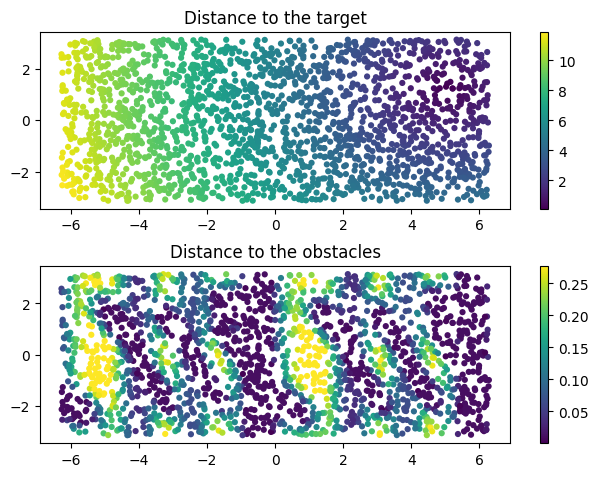

In [122]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False): 0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance

def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = RAND_CONF(False)
          if not coll(q):
               hfree.append( list(q.flat) + [ distance(q,q_goal), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ distance(q,q_goal), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()
     plt.tight_layout(pad=0.8)

hcol,hfree = sampleSpace(2000) #increase to improve resolution
plotConfigurationSpace(hcol,hfree)


Let's display the path:

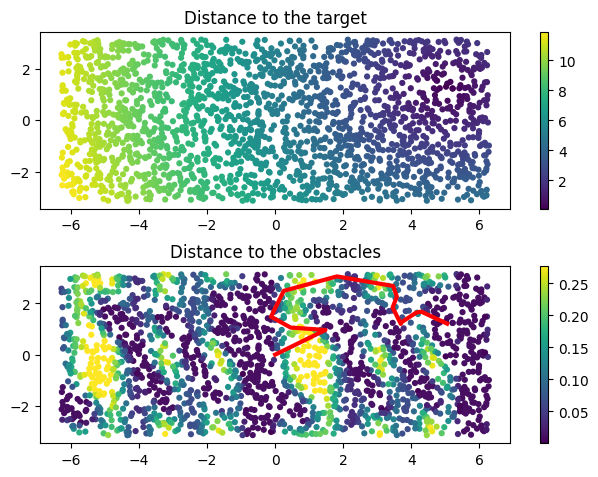

In [123]:
def plotpaths(paths, colors = ['r','c']):
    plotConfigurationSpace(hcol,hfree)
    for path, color in zip(paths,colors):
        patharray = np.array(path)
        plt.plot(patharray[:,0],patharray[:,1],color,lw=3)
    
plotpaths([path])

## Writing a shortcut for the path
Let's see if we can try to reduce the length of a path we obtained.
Simply reasoning on the nodes in the path, try to come up by yourself with a mean to reduce the length. A solution is provided below if you need it but is by no mean the only approach.

Hopefully by now you will have understood that RRT is a very simple algorithm which is very generic (which is why it is so appreciated) and subject to an infinity of specialisations.


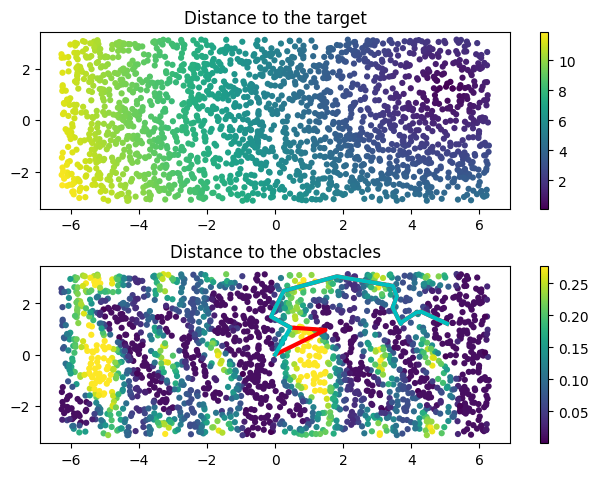

In [124]:
def shortcut(path):
    for i, q in enumerate(path):
        for j in reversed(range(i+1,len(path))):
            q2 = path[j]
            q_new = NEW_CONF(q,q2,discretisationsteps_newconf, delta_q = delta_q)
            if VALID_EDGE(q,q2,discretisationsteps_validedge):
                path = path[:i+1]+path[j:]
                return path
    return path


colors = ["b","c","m","y"]
originalpath = path[:]
shortcutpath = originalpath[:]

for _ in range(10):
    shortcutpath = shortcut(shortcutpath)
        
plotpaths([originalpath,shortcutpath])

displaypath(originalpath)
displaypath(shortcutpath)